# Cliff Walking
## Q-learning vs Sarsa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import cv2

In [2]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")

In [3]:
def generate_video(
    frames:list,
    output_name:str='output.mp4',
    fps:float=1.5, 
    shape:tuple=(240, 720)
):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_name, fourcc, fps, shape)
    for frame in frames:
        frame = frame[:, :, ::-1]
        video_writer.write(frame)
    video_writer.release()

In [4]:
def epsilon_soft(Q:np.ndarray, state:int, num_actions:int, epsilon:float):
    if np.random.rand() < epsilon:
        return np.random.randint(0, high=num_actions)

    a_star = np.argmax(Q[state])
    return a_star


def TD_Zero(Q:np.ndarray, episodes:int, gamma:float=1.0, alpha=0.1, epsilon=0.1, verbose=True):
    Q = Q.copy()
    history = []
    sum_rewards = 0

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_soft(Q=Q, state=state, num_actions=env.action_space.n, epsilon=epsilon)
        history.append(sum_rewards)
        sum_rewards = 0
        terminated = False
        while not terminated:
            new_state, reward, terminated, _, _ = env.step(action)
            new_action = epsilon_soft(Q=Q, state=new_state, num_actions=env.action_space.n, epsilon=epsilon)
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * Q[new_state, new_action] - Q[state, action])
            state = new_state
            action = new_action
            sum_rewards += reward
            
        if verbose:
            print(f'\rEpisode: {episode:>4} Rewards: {sum_rewards:>5}', end='')

    if verbose:
        print()
    return Q, history

In [5]:
def Q_learning(Q:np.ndarray, episodes:int, gamma:float=1.0, alpha=0.1, epsilon=0.1, verbose=True):
    Q = Q.copy()
    history = []
    sum_rewards = 0

    for episode in range(episodes):
        state, _ = env.reset()
        history.append(sum_rewards)
        sum_rewards = 0
        terminated = False
        while not terminated:
            action = epsilon_soft(Q=Q, state=state, num_actions=env.action_space.n, epsilon=epsilon)
            new_state, reward, terminated, _, _ = env.step(action)
            max_q = np.max(Q[new_state])
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * max_q - Q[state, action])
            state = new_state
            sum_rewards += reward
            
        if verbose:
            print(f'\rEpisode: {episode:>4} Rewards: {sum_rewards:>5}', end='')

    if verbose:
        print()
    return Q, history

In [24]:
running_sarsa_history = np.zeros(shape=(500,))
for run in range(100):
    Q = np.zeros(shape=[48, 4], dtype=np.float32)
    Q_sarsa, sarsa_history = TD_Zero(Q=Q, episodes=500, alpha=0.2, verbose=False)
    running_sarsa_history = running_sarsa_history + (1 / (run + 1)) * (np.array(sarsa_history) - running_sarsa_history)
    print(f'\rRun: {run + 1:>5}', end='')

Run:   100

In [25]:
running_qlearning_history = np.zeros(shape=(500,))
for run in range(100):
    Q = np.zeros(shape=[48, 4], dtype=np.float32)
    Q_qlearning, qlearning_history = Q_learning(Q=Q, alpha=0.2, episodes=500, verbose=False)
    running_qlearning_history = running_qlearning_history + (1 / (run + 1)) * (np.array(qlearning_history) - running_qlearning_history)
    print(f'\rRun: {run + 1:>5}', end='')

Run:   100

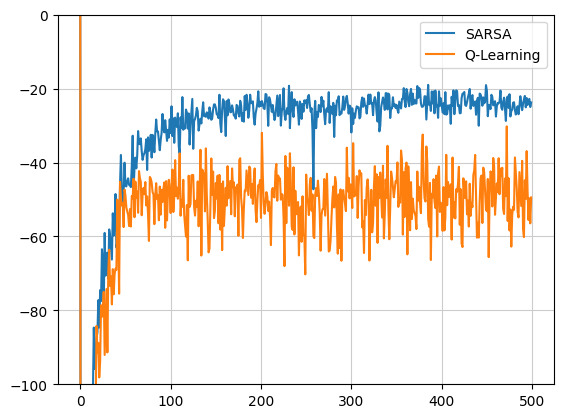

In [26]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(running_sarsa_history, label='SARSA')
ax.plot(running_qlearning_history, label='Q-Learning')
ax.set_ylim([-100, 0])
ax.grid(c='#ccc')
ax.legend();

In [27]:
frames = []
state, _ = env.reset()
frames.append(env.render())
terminated = False
while not terminated:
    action = epsilon_soft(Q=Q_sarsa, state=state, num_actions=4, epsilon=0)
    state, reward, terminated, _, _ = env.step(action)
    frames.append(env.render())

generate_video(frames, output_name='cliff_walk_sarsa.mp4', fps=3, shape=(720, 240))

In [28]:
frames = []
state, _ = env.reset()
frames.append(env.render())
terminated = False
while not terminated:
    action = epsilon_soft(Q=Q_qlearning, state=state, num_actions=4, epsilon=0)
    state, reward, terminated, _, _ = env.step(action)
    frames.append(env.render())

generate_video(frames, output_name='cliff_walk_qlearning.mp4', fps=3, shape=(720, 240))

## Expected Sarsa

In [29]:
def Expected_Sarsa(Q:np.ndarray, episodes:int, gamma:float=1.0, alpha=0.1, epsilon=0.1, verbose=True):
    Q = Q.copy()
    history = []
    sum_rewards = 0

    for episode in range(episodes):
        state, _ = env.reset()
        history.append(sum_rewards)
        sum_rewards = 0
        terminated = False
        while not terminated:
            action = epsilon_soft(Q=Q, state=state, num_actions=env.action_space.n, epsilon=epsilon)
            new_state, reward, terminated, _, _ = env.step(action)

            a_star = np.argmax(Q[new_state])
            expectation = 0
            num_actions = Q.shape[-1]
            for a in range(num_actions):
                if a == a_star:
                    expectation += (1 - epsilon + epsilon / num_actions) * Q[new_state, a]
                else:
                    expectation += (epsilon / num_actions) * Q[new_state, a]
            
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * expectation - Q[state, action])
            state = new_state
            sum_rewards += reward
            
        if verbose:
            print(f'\rEpisode: {episode:>4} Rewards: {sum_rewards:>5}', end='')

    if verbose:
        print()
    return Q, history

In [36]:
running_expected_sarsa_history = np.zeros(shape=(500,))
for run in range(100):
    Q = np.zeros(shape=[48, 4], dtype=np.float32)
    Q_expected_sarsa, expected_sarsa_history = Expected_Sarsa(Q=Q, alpha=0.2, episodes=500, verbose=False)
    running_expected_sarsa_history = running_expected_sarsa_history + (1 / (run + 1)) * \
                                    (np.array(expected_sarsa_history) - running_expected_sarsa_history)
    print(f'\rRun: {run + 1:>5}', end='')

Run:   100

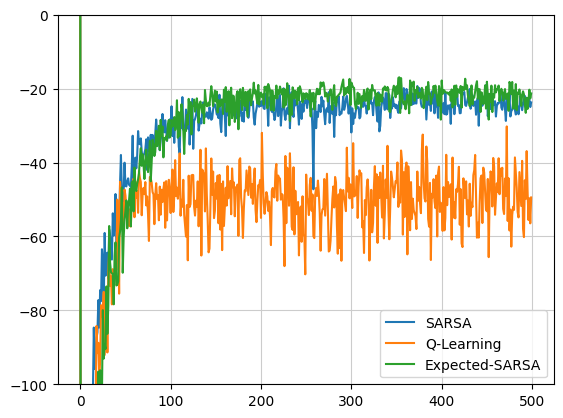

In [37]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(running_sarsa_history, label='SARSA')
ax.plot(running_qlearning_history, label='Q-Learning')
ax.plot(running_expected_sarsa_history, label='Expected-SARSA')
ax.set_ylim([-100, 0])
ax.grid(c='#ccc')
ax.legend();

In [38]:
frames = []
state, _ = env.reset()
frames.append(env.render())
terminated = False
while not terminated:
    action = epsilon_soft(Q=Q_expected_sarsa, state=state, num_actions=4, epsilon=0)
    state, reward, terminated, _, _ = env.step(action)
    frames.append(env.render())

generate_video(frames, output_name='cliff_walk_expected_sarsa.mp4', fps=3, shape=(720, 240))